Generate data sample

In [1]:
from utils import generate_sample
import numpy as np

target_func = lambda X: (20 + X**2 - 10 * np.cos(2*np.pi*X)).sum(axis=0)

n = 70
n_dims = 2
lower_bound = -2.5, -1.5
upper_bound = +1.5, +2.5

In [2]:
X, y = generate_sample(n, n_dims, lower_bound, upper_bound, target_func)

Text(0.5, 0, '$x_1$')

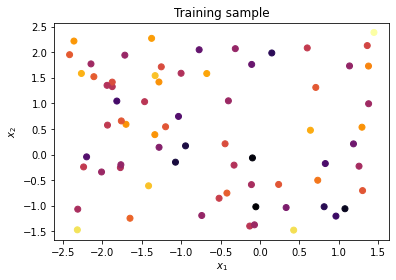

In [3]:
import matplotlib.pyplot as plt

plt.scatter(X[0], X[1], c=y, cmap="inferno")
plt.title("Training sample")
plt.ylabel("$x_2$")
plt.xlabel("$x_1$")

Train Default Gaussian Process Model

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.optimize import differential_evolution
gpr = GaussianProcessRegressor(optimizer=differential_evolution)
gpr.fit(X.T, y)
y_pred = gpr.predict(X.T)

In [5]:
print(gpr.log_marginal_likelihood_value_)
print(gpr.optimizer)

-538550275.748918
<function differential_evolution at 0x00000207968F1678>


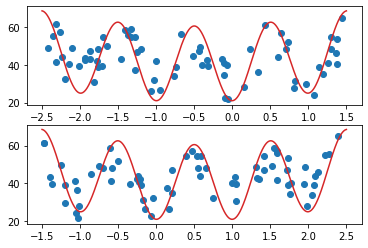

In [11]:
m = np.arange(-2.5,1.5,0.001)
p = np.arange(-1.5,2.5,0.001)
y_all = target_func(np.array([m,p]))

plt.subplot(211)
plt.plot(m,y_all, color='tab:red')
plt.scatter(X[0], y_pred)

plt.subplot(212)
plt.plot(p,y_all, color='tab:red')
plt.scatter(X[1], y_pred)

plt.show()

In [12]:
m = np.arange(-2.5,1.5,0.001)
p = np.arange(-1.5,2.5,0.001)
X = np.array(np.meshgrid(m, p))
Y = np.zeros((4000,4000))
for i in range(len(X.T)):
    Y[i] = gpr.predict(X.T[i])

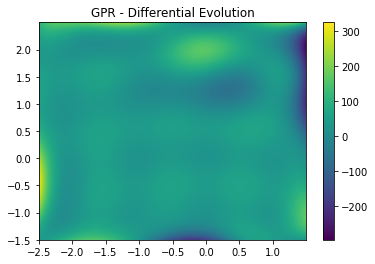

In [13]:
plt.pcolormesh(np.array(np.meshgrid(m, p))[0], np.array(np.meshgrid(m, p))[1], Y)
plt.colorbar()
plt.title("GPR - Differential Evolution")
plt.show()

Groundtruth

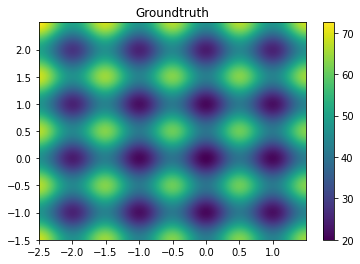

In [51]:
from utils import visualize_meshgrid
m = np.arange(-2.5,1.5,0.001)
p = np.arange(-1.5,2.5,0.001)
visualize_meshgrid(m, p, target_func, title='Groundtruth')